In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2018 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# Cross Section Analysis

The MetPy function `metpy.interpolate.cross_section` can obtain a cross-sectional slice through
gridded data.

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section

**Getting the data**

This example uses [NARR reanalysis data](
https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional)
for 18 UTC 04 April 1987 from NCEI.

We use MetPy's CF parsing to get the data ready for use, and squeeze down the size-one time
dimension.

In [4]:
data = xr.open_dataset(get_test_data('narr_example.nc', False))
data = data.metpy.parse_cf().squeeze()
print(data)

<xarray.Dataset> Size: 21MB
Dimensions:              (isobaric: 29, y: 118, x: 292)
Coordinates:
  * isobaric             (isobaric) float64 232B 1e+03 975.0 ... 125.0 100.0
  * y                    (y) float64 944B -3.087e+06 -3.054e+06 ... 7.114e+05
  * x                    (x) float64 2kB -3.977e+06 -3.945e+06 ... 5.47e+06
    time                 datetime64[ns] 8B 1987-04-04T18:00:00
    metpy_crs            object 8B Projection: lambert_conformal_conic
Data variables:
    Temperature          (isobaric, y, x) float32 4MB ...
    Lambert_Conformal    |S1 1B ...
    lat                  (y, x) float64 276kB ...
    lon                  (y, x) float64 276kB ...
    u_wind               (isobaric, y, x) float32 4MB ...
    v_wind               (isobaric, y, x) float32 4MB ...
    Geopotential_height  (isobaric, y, x) float32 4MB ...
    Specific_humidity    (isobaric, y, x) float32 4MB ...
Attributes: (12/14)
    Conventions:              CF-1.0
    Originating_center:       US Nation

Define start and end points:

In [5]:
start = (37.0, -105.0)
end = (35.5, -65.0)

Get the cross section, and convert lat/lon to supplementary coordinates:

In [6]:
cross = cross_section(data, start, end).set_coords(('lat', 'lon'))
print(cross)

<xarray.Dataset> Size: 120kB
Dimensions:              (isobaric: 29, index: 100)
Coordinates:
  * isobaric             (isobaric) float64 232B 1e+03 975.0 ... 125.0 100.0
  * index                (index) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    time                 datetime64[ns] 8B 1987-04-04T18:00:00
    metpy_crs            object 8B Projection: lambert_conformal_conic
    x                    (index) float64 800B 1.818e+05 2.18e+05 ... 3.712e+06
    y                    (index) float64 800B -1.454e+06 ... -5.573e+05
    lat                  (index) float64 800B 37.0 37.05 37.11 ... 35.58 35.5
    lon                  (index) float64 800B -105.0 -104.6 ... -65.39 -65.0
Data variables:
    Temperature          (isobaric, index) float64 23kB 287.7 286.9 ... 211.4
    Lambert_Conformal    |S1 1B ...
    u_wind               (isobaric, index) float64 23kB -2.729 0.4776 ... 23.68
    v_wind               (isobaric, index) float64 23kB 8.473 5.723 ... -1.082
    Geopotential_hei

For this example, we will be plotting potential temperature, relative humidity, and
tangential/normal winds. And so, we need to calculate those, and add them to the dataset:

In [7]:
cross['Potential_temperature'] = mpcalc.potential_temperature(
    cross['isobaric'],
    cross['Temperature']
)
cross['Relative_humidity'] = mpcalc.relative_humidity_from_specific_humidity(
    cross['isobaric'],
    cross['Temperature'],
    cross['Specific_humidity']
)
cross['u_wind'] = cross['u_wind'].metpy.convert_units('knots')
cross['v_wind'] = cross['v_wind'].metpy.convert_units('knots')
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(
    cross['u_wind'],
    cross['v_wind']
)

print(cross)

<xarray.Dataset> Size: 213kB
Dimensions:                (isobaric: 29, index: 100)
Coordinates:
  * isobaric               (isobaric) float64 232B 1e+03 975.0 ... 125.0 100.0
  * index                  (index) int64 800B 0 1 2 3 4 5 ... 94 95 96 97 98 99
    time                   datetime64[ns] 8B 1987-04-04T18:00:00
    metpy_crs              object 8B Projection: lambert_conformal_conic
    x                      (index) float64 800B 1.818e+05 2.18e+05 ... 3.712e+06
    y                      (index) float64 800B -1.454e+06 ... -5.573e+05
    lat                    (index) float64 800B 37.0 37.05 37.11 ... 35.58 35.5
    lon                    (index) float64 800B -105.0 -104.6 ... -65.39 -65.0
Data variables:
    Temperature            (isobaric, index) float64 23kB 287.7 286.9 ... 211.4
    Lambert_Conformal      |S1 1B ...
    u_wind                 (isobaric, index) float64 23kB <Quantity([[ -5.304...
    v_wind                 (isobaric, index) float64 23kB <Quantity([[16.4704.

Now, we can make the plot.

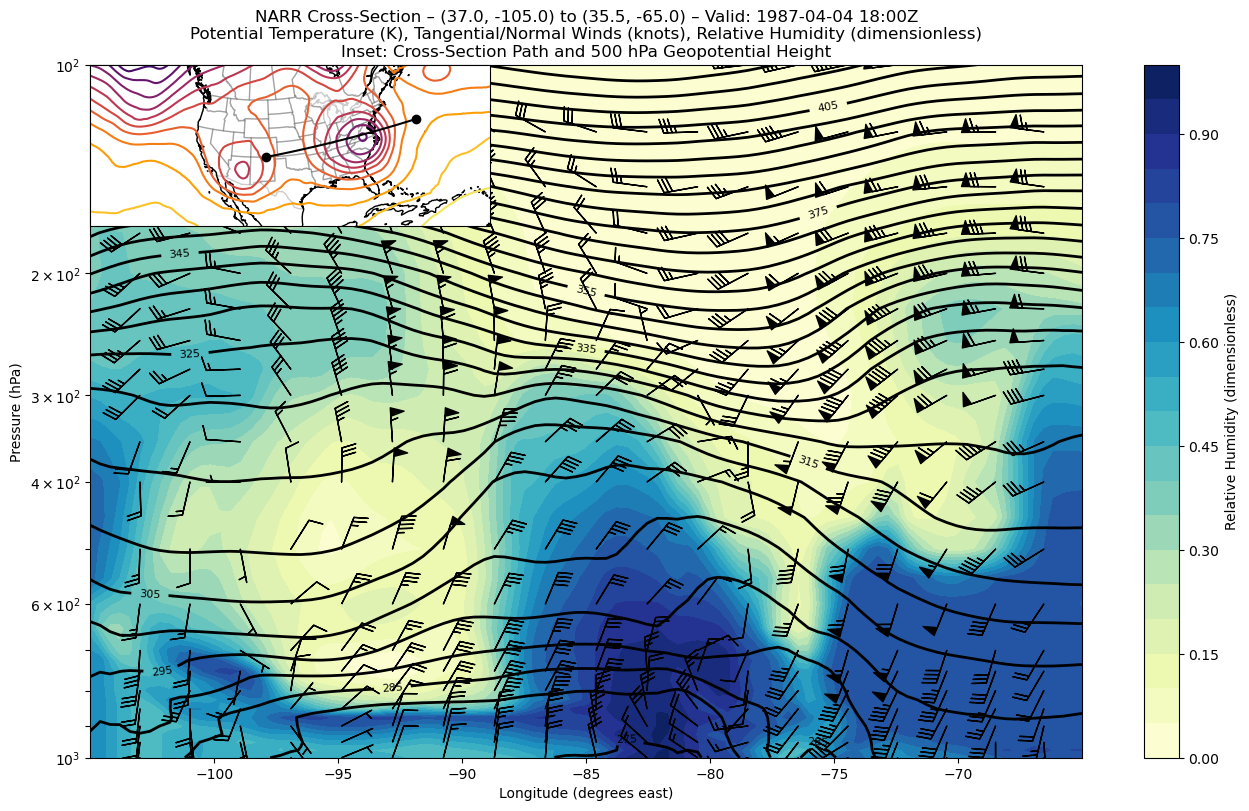

In [8]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['lon'], cross['isobaric'], cross['Relative_humidity'],
                         levels=np.arange(0, 1.05, .05), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['lon'], cross['isobaric'], cross['Potential_temperature'],
                           levels=np.arange(250, 450, 5), colors='k', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
wind_slc_vert = list(range(0, 19, 2)) + list(range(19, 29))
wind_slc_horz = slice(5, 100, 5)
ax.barbs(cross['lon'][wind_slc_horz], cross['isobaric'][wind_slc_vert],
         cross['t_wind'][wind_slc_vert, wind_slc_horz],
         cross['n_wind'][wind_slc_vert, wind_slc_horz], color='k')

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_ylim(cross['isobaric'].max(), cross['isobaric'].min())
ax.set_yticks(np.arange(1000, 50, -100))

# Define the CRS and inset axes
data_crs = data['Geopotential_height'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['x'], data['y'], data['Geopotential_height'].sel(isobaric=500.),
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['x'], cross['y'], c='k', zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
ax.set_title(f'NARR Cross-Section \u2013 {start} to {end} \u2013 '
             f'Valid: {cross["time"].dt.strftime("%Y-%m-%d %H:%MZ").item()}\n'
             'Potential Temperature (K), Tangential/Normal Winds (knots), Relative Humidity '
             '(dimensionless)\nInset: Cross-Section Path and 500 hPa Geopotential Height')
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
rh_colorbar.set_label('Relative Humidity (dimensionless)')

plt.show()

Note: The x-axis can display any variable that is the same length as the
plotted variables, including latitude. Additionally, arguments can be provided
to ``ax.set_xticklabels`` to label lat/lon pairs, similar to the default NCL output.